# **PROPOSITION D’UN ALGORITHME DE DEEP LEARNING POUR LA CLASSIFICATION DE MAMMOGRAPHIES.**

# **CONNEXION DE MON GOOGLE DRIVE A GOOGLE COLAB**

In [5]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!ls "/content/gdrive/My Drive/Breast_Cancer_DDSM/"


Test  Train_Vald


# **INSTALLATION DE TENSORFLOW ET IMPORTATION DE BIBLIOTHEQUES**

#### **Installation de bibliothèques de Python.**

In [ ]:
!pip install split-folders matplotlib opencv-python spicy --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#### **Installation de TensorFlow.**

In [ ]:
# INSTALLATION DE TensorFlow
!pip install tensorflow --upgrade


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#### **Mise à jour de Keras.**

In [ ]:
# Mise à jour de Keras
!pip install keras --upgrade

#### **Installation de bibliothèques.**

In [6]:

import numpy as np
import cv2 
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras import layers
from keras import Model 
from keras.optimizers import Adam
from sklearn import metrics
#from tensorflow.keras.applications.resnet50 import ResNet50
#from tensorflow.keras.applications import resnet50
from keras.applications import ResNet50
from keras.applications import ResNet101
from keras.applications import ResNet152
from keras.callbacks import EarlyStopping
from keras.applications.resnet import preprocess_input

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix




In [7]:
import random
random.seed(42)
from numpy.random import seed
seed=42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# **CHARGEMENT, EXPLORATION ET PREPARATION DES DONNEES**

## **Importation des images (matrices de pixels) en des tableaux numpy et redimensionnement en *224x224*.**

###### Fonction d'importation.

In [8]:
# FONCTION D(IMPORTATION 

import json
from PIL import Image
from tqdm import tqdm

def Dataset_loader(DIR, RESIZE,  sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png": 
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG

###### Importation des images tout en les redimensionnant en 224x224.

In [9]:
# IMPORTATION

### Données d'apprentissage 
nor_Train = np.array(Dataset_loader("/content/gdrive/MyDrive/Breast_Cancer_DDSM/Train_Vald/normal",224))
ben_Train = np.array(Dataset_loader("/content/gdrive/MyDrive/Breast_Cancer_DDSM/Train_Vald/benign",224))
can_Train = np.array(Dataset_loader("/content/gdrive/MyDrive/Breast_Cancer_DDSM/Train_Vald/cancer",224))

### Données de test
nor_Test = np.array(Dataset_loader("/content/gdrive/MyDrive/Breast_Cancer_DDSM/Test/normal",224))
ben_Test = np.array(Dataset_loader("/content/gdrive/MyDrive/Breast_Cancer_DDSM/Test/benign",224))
can_Test = np.array(Dataset_loader("/content/gdrive/MyDrive/Breast_Cancer_DDSM/Test/cancer",224))

100%|██████████| 100/100 [00:03<00:00, 31.69it/s]


### **Visualisation des données.**

### La forme des données:

>


In [ ]:
print("Normal train :",nor_Train.shape) 
print("Benign train  :",ben_Train.shape) 
print("Cancer train  : ",can_Train.shape) 

Normal train : (200, 224, 224, 3)
Benign train  : (200, 224, 224, 3)
Cancer train  :  (200, 224, 224, 3)


In [ ]:
print("Normal test :",nor_Test.shape) 
print("Benign test :",ben_Test.shape) 
print("Cancer test  : ",can_Test.shape) 

Normal test : (100, 224, 224, 3)
Benign test : (100, 224, 224, 3)
Cancer test  :  (100, 224, 224, 3)


#### Visualisation de quelques images:

**QUELQUES IMAGES DE SEINS NORMAUX:


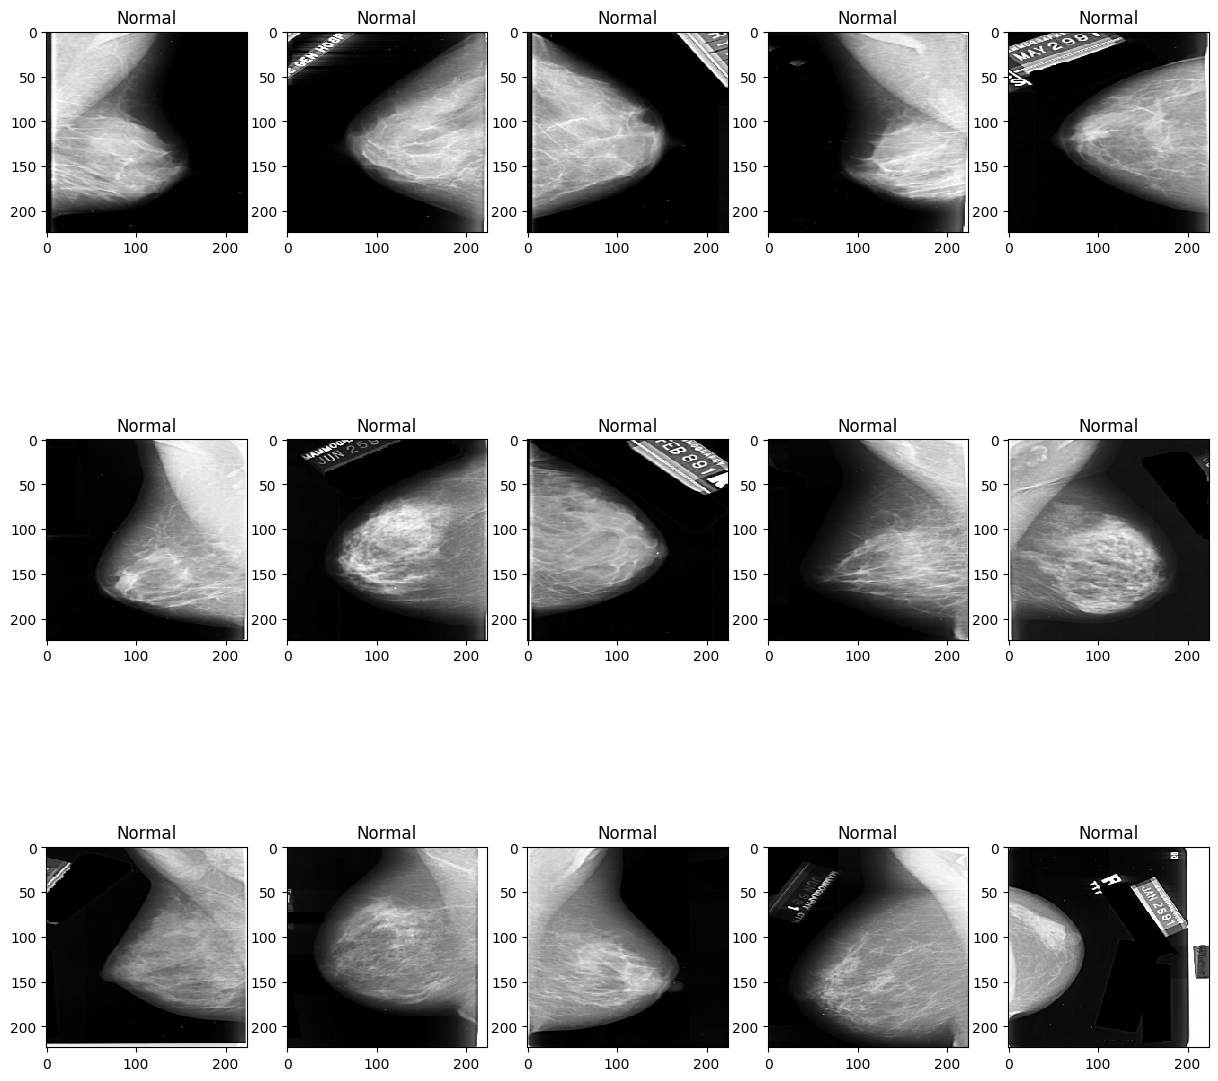

In [7]:
print("**QUELQUES IMAGES DE SEINS NORMAUX:")

fig=plt.figure(figsize=(15, 15))
columns =5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    ax.title.set_text('Normal')
    plt.imshow(nor_Train[i], interpolation='nearest')
   
plt.show()

**QUELQUES IMAGES DE SEINS AVEC MASSE BENIGNE:


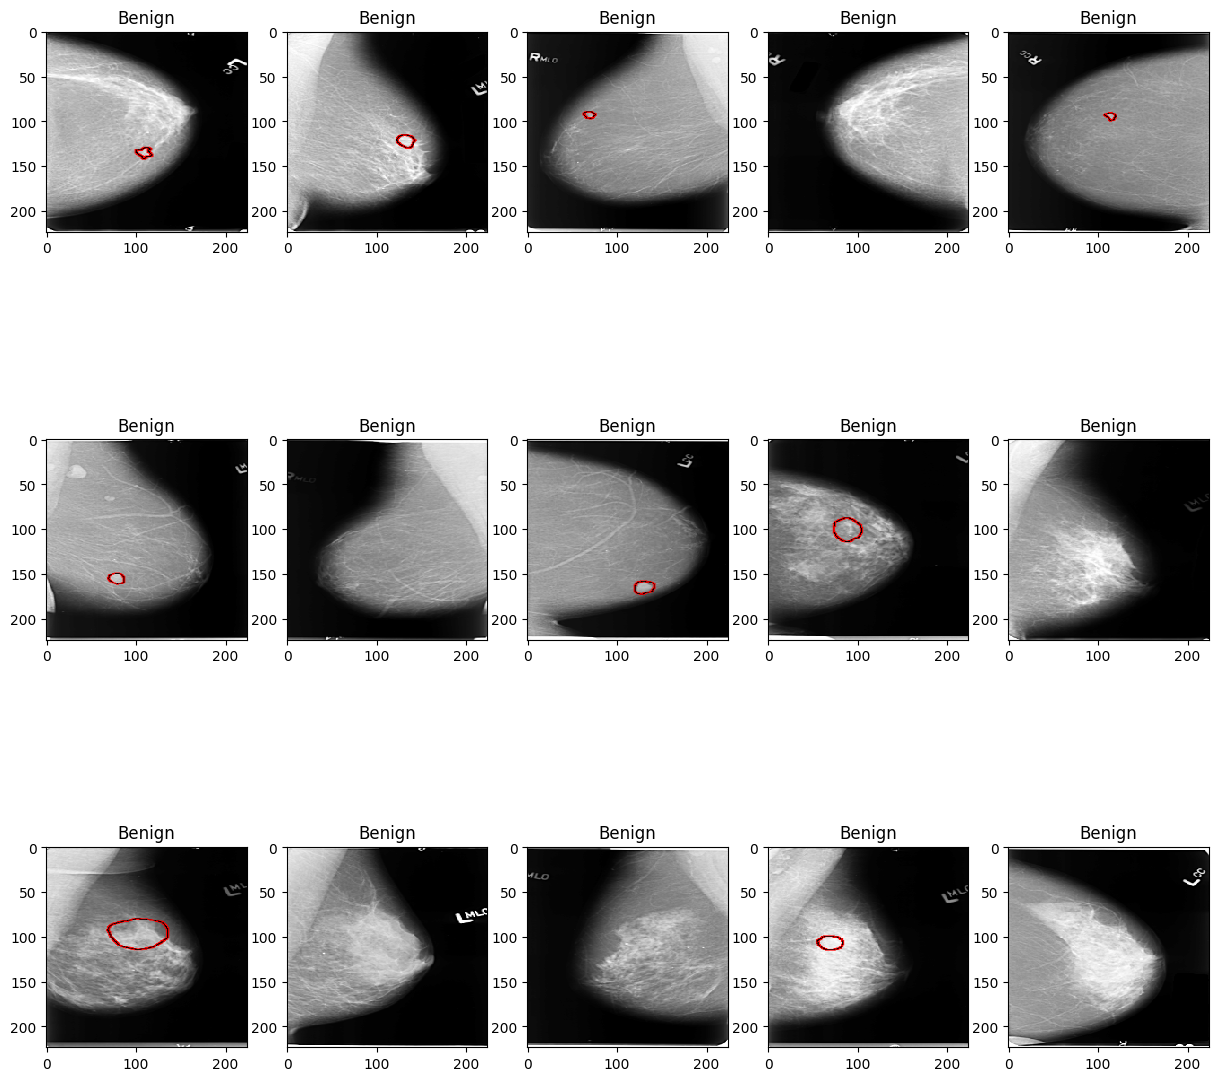

In [8]:
print("**QUELQUES IMAGES DE SEINS AVEC MASSE BENIGNE:")

fig=plt.figure(figsize=(15, 15))
columns =5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    ax.title.set_text('Benign')
    plt.imshow(ben_Train[i], interpolation='nearest')
   
plt.show()

**QUELQUES IMAGES DE SEINS CANCEREUX:


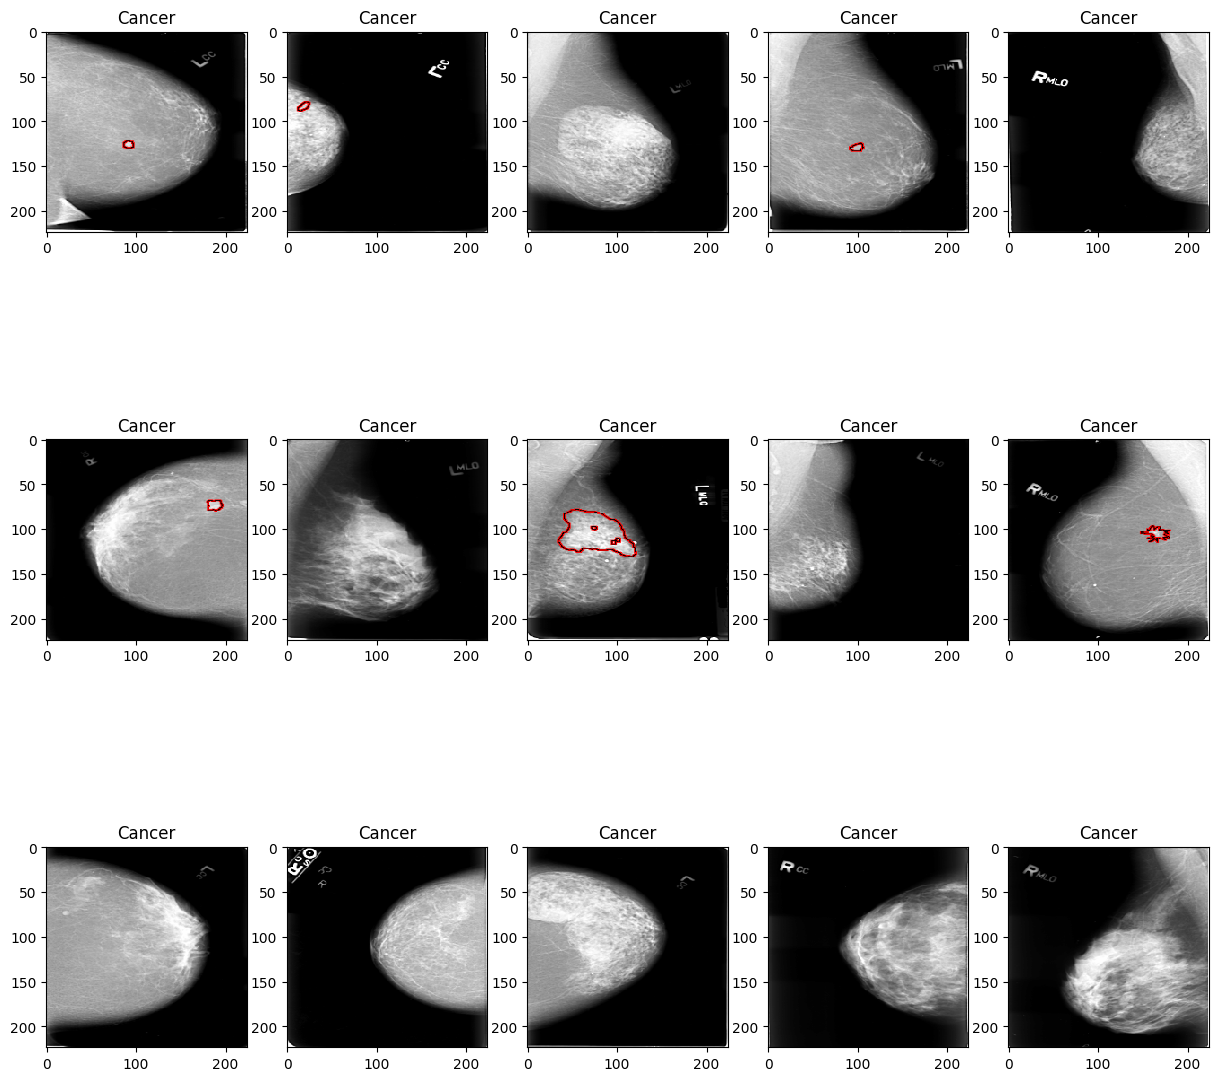

In [9]:
print("**QUELQUES IMAGES DE SEINS CANCEREUX:")

fig=plt.figure(figsize=(15, 15))
columns =5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    ax.title.set_text('Cancer')
    plt.imshow(can_Train[i], interpolation='nearest')
   
plt.show()

## **Création d'un vecteur numpy de zéros pour étiqueter les images normales, d'un tableau numpy de 1 pour étiqueter les images bénignes et d'un tableau numpy de 2 pour étiqueter les images malignes (cancer).**

#### Données d'entrainement:

In [10]:
nor_Train_label = np.tile(0,len(nor_Train))
ben_Train_label = np.tile(1,len(ben_Train))
can_Train_label = np.tile(2, len(can_Train))

#### Données de test:

In [11]:
nor_Test_label = np.tile(0,len(nor_Test))
ben_Test_label = np.tile(1,len(ben_Test))
can_Test_label = np.tile(2, len(can_Test))

# **Découpage des données d'apprentissage en données  Train et de validation.**

In [12]:
## LES IMAGES
train_normal, vald_normal =  train_test_split(nor_Train, test_size=0.2,random_state=seed)
train_benign, vald_benign = train_test_split(ben_Train, test_size=0.2,random_state=seed)
train_cancer, vald_cancer = train_test_split(can_Train, test_size=0.2,random_state=seed)


## LES ETIQUETTES
train_normal_label, vald_normal_label = train_test_split(nor_Train_label, test_size=0.2,random_state=seed)
train_benign_label, vald_benign_label = train_test_split(ben_Train_label, test_size=0.2,random_state=seed)
train_cancer_label, vald_cancer_label= train_test_split(can_Train_label, test_size=0.2,random_state=seed)



## **Mélange de l'ensemble des données.**

In [13]:
# CONCATENATION IMAGES
train = np.concatenate((train_normal, train_benign, train_cancer), axis = 0)
vald = np.concatenate((vald_normal, vald_benign, vald_cancer), axis = 0)
test = np.concatenate((nor_Test, ben_Test, can_Test), axis = 0)

# CONCATENATION ETIQUETTES
train_labels = np.concatenate((train_normal_label, train_benign_label, train_cancer_label), axis = 0)
vald_labels = np.concatenate((vald_normal_label, vald_benign_label, vald_cancer_label), axis = 0)
test_labels = np.concatenate((nor_Test_label, ben_Test_label, can_Test_label), axis = 0)

# MELANGE
s1 = np.arange(train.shape[0])
np.random.shuffle(s1)
Train  = train[s1]
Train_labels = train_labels[s1]

s2 = np.arange(vald.shape[0])
np.random.shuffle(s2)
Vald  = vald[s2]
Vald_labels = vald_labels[s2]

s3 = np.arange(test.shape[0])
np.random.shuffle(s3)
Test  = test[s3]
Test_labels = test_labels[s3]

#### ***Répartition des étiquettes :***

In [46]:
# LES DONNEES TRAIN
pd.DataFrame(Train_labels)[0].value_counts()

2    160
0    160
1    160
Name: 0, dtype: int64

In [ ]:
Train.shape

(480, 224, 224, 3)

In [ ]:
# LES DONNEES DE VALIDATION
pd.DataFrame(Vald_labels)[0].value_counts()

1    40
2    40
0    40
Name: 0, dtype: int64

In [ ]:
Vald.shape

(120, 224, 224, 3)

In [17]:
# LES DONNEES TEST
pd.DataFrame(Test_labels)[0].value_counts()

1    100
0    100
2    100
Name: 0, dtype: int64

In [ ]:
Test.shape

(300, 224, 224, 3)

## **Convertion des étiquettes au format catégoriel**

In [14]:
Train_labels = to_categorical(Train_labels, num_classes= 3)
Vald_labels = to_categorical(Vald_labels, num_classes= 3)
Test_labels = to_categorical(Test_labels, num_classes= 3)


In [15]:
Train_labels

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

## **Visualisation de quelques images de l'ensemble des données d'entrainement**

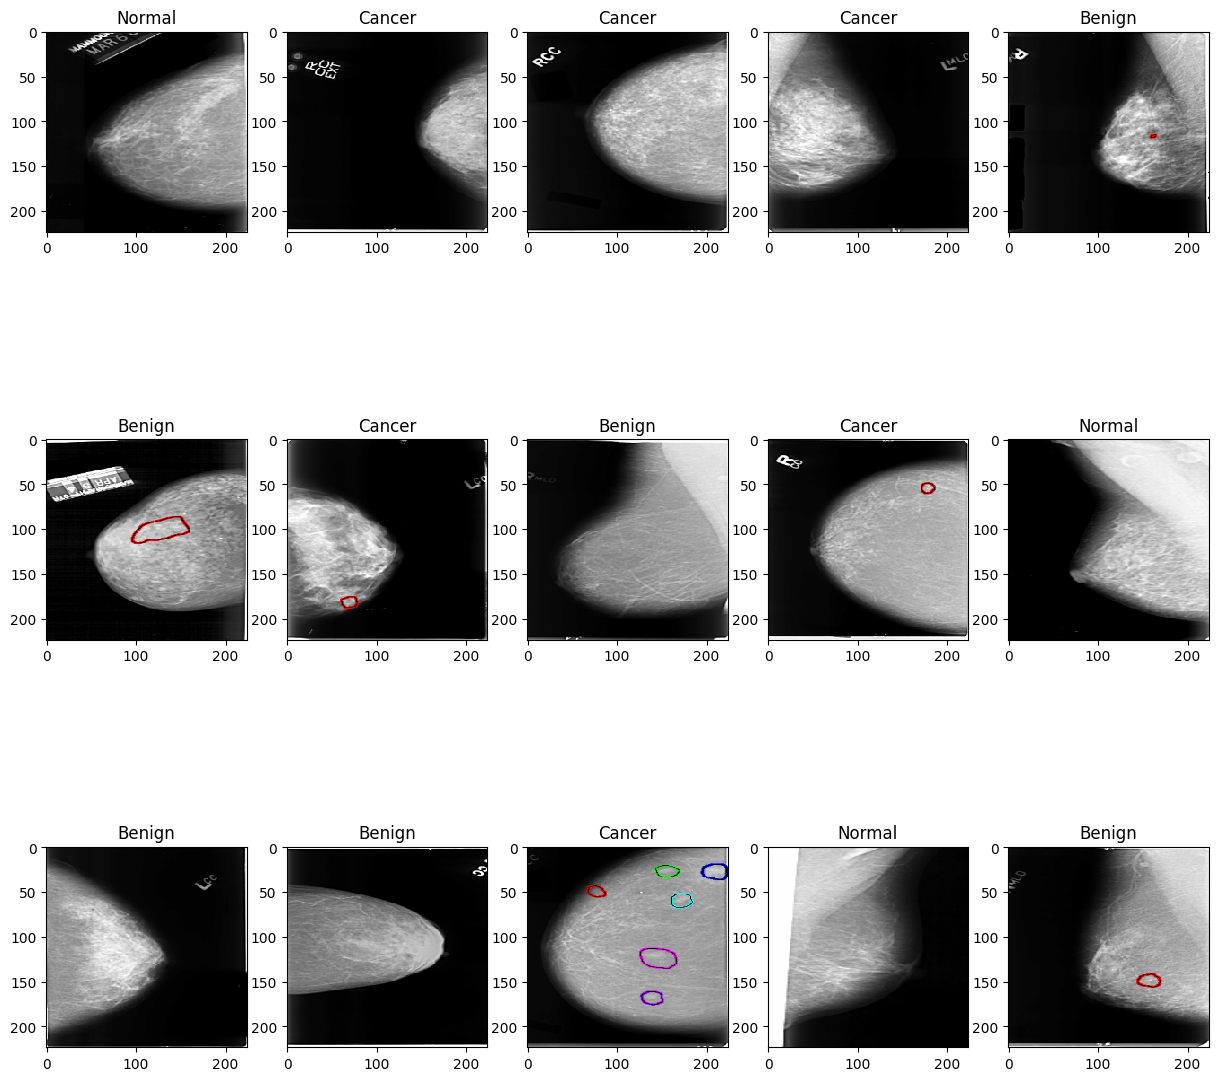

In [48]:
fig=plt.figure(figsize=(15, 15))
columns =5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Train_labels[i]) == 0:
        ax.title.set_text('Normal')
        
    if np.argmax(Train_labels[i]) != 0:
        if np.argmax(Train_labels[i]) == 1:
          ax.title.set_text('Benign') 
        else:
          ax.title.set_text('Cancer')
       
    plt.imshow(Train[i], interpolation='nearest')
   
plt.show()

# **SELECTION DE MODELES PRE - ENTRAINES ET CREATION DE MODELES DE BASE**
#### **(TRANSFER LEARNING).**

#### **Avec extraction de caractéristiques:**

In [16]:
Fex_model_resn50 = keras.applications.ResNet50( weights='imagenet',  # Chargement des poids pré-formés sur ImageNet.
    input_shape=None,
    include_top=False # Ne pas inclure la couche entièrement connectée en haut du réseau pré-formé sur ImageNet.
    )   

Fex_model_resn101 = keras.applications.ResNet101(weights='imagenet',input_shape=None, include_top=False)

Fex_model_resn152 = keras.applications.ResNet152(weights='imagenet',input_shape=None, include_top=False)

# GEL DES COUCHES DES MODELES DE BASES POUR NE PAS QU'ELLES SOIENT MISES A JOUR PENDANT L'ENTRAINEMENT.
# Le modèle de base contient des couches entrainables. Ici, nous les gardons en mode inférence,
# c'est-à-dire on entraîne seulement le nouveau classifieur et on ne ré-entraîne pas les autres couches
for layer in Fex_model_resn50.layers:
  Fex_model_resn50.trainable = False 

for layer in Fex_model_resn101.layers:
  Fex_model_resn101.trainable = False

for layer in Fex_model_resn152.layers:
  Fex_model_resn152.trainable = False

234698864/234698864 [==============================] - 11s 0us/step


#### **Avec Fine Turning total:**

In [17]:
FTt_model_resn50 = keras.applications.ResNet50(weights='imagenet', # Chargement des poids pré-formés sur ImageNet.
    input_shape=(224,224,3),
    include_top=False # Ne pas inclure la couche entièrement connectée en haut du réseau pré-formé sur ImageNet.
)   

FTt_model_resn101 = keras.applications.ResNet101(weights='imagenet', input_shape=(224,224,3), include_top=False)

FTt_model_resn152 = keras.applications.ResNet152(weights='imagenet', input_shape=(224,224,3), include_top=False)

# ON NE GELE PAS LES COUCHES DES MODELES DE BASES, ON LES LAISSE SE METTRE A JOUR PENDANT L'ENTRAINEMENT.
# Ici, on entraîne tout le réseau, donc il faut rendre toutes les couches "entraînables".

for layer in FTt_model_resn50.layers:
  FTt_model_resn50.trainable = True 

for layer in FTt_model_resn101.layers:
  FTt_model_resn101.trainable = True

for layer in FTt_model_resn152.layers:
  FTt_model_resn152.trainable = True

# **CREATION DE NOUVEAUX MODELES PAR - DESSUS NOS MODELES DE BASE.**

##### *Cette étape consiste à ajouter de nouvelles couches entraînables qui transformeront les anciennes fonctionnalités en prédictions sur le nouvel ensemble de données. Ceci est important car les modèles pré-entraînés sont chargés sans leurs couches de sortie finale (Les couches entièrement connectées).*

#### **Augmentation aléatoire des données**

In [18]:
data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"), layers.RandomRotation(0.1)]
)
 
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)

#### **Création des couches supérieures des modèles de base:**

##### **Au-dessus des modèles Fex_model_resn50 et FTt_model_resn50.**

In [19]:
# Application de l'augmentation et prétraitement des données d'entrées

# Le modèle de base Fex_model_resn50
x50 = tf.keras.applications.resnet50.preprocess_input(x)
x50 = Fex_model_resn50(x50, training=False)
x50 = tf.keras.layers.GlobalAveragePooling2D()(x50) # Convertir des caractéristiques d'images en un seul vecteur
#x50 = tf.keras.layers.Flatten()(x50 )
x50 = tf.keras.layers.Dropout(0.2)(x50)  
outputs = tf.keras.layers.Dense(3, activation='softmax')(x50)
Fex_resn50 = tf.keras.Model(inputs, outputs)

# Le modèle de base FTt_model_resn50
x502 = tf.keras.applications.resnet50.preprocess_input(x)
x502 = FTt_model_resn50(x502, training=True)
x502 = tf.keras.layers.GlobalAveragePooling2D()(x502)
#x502 = tf.keras.layers.Flatten()(x502 )
x502 = tf.keras.layers.Dropout(0.2)(x502)  # Regularisation avec dropout
outputs = tf.keras.layers.Dense(3, activation='softmax')(x502)
FTt_resn50 = tf.keras.Model(inputs, outputs)


##### **Au-dessus du modèle Fex_model_resn101 et FTt_model_resn101.**

In [20]:
# Le modèle de base Fex_model_resn101.
x101 = tf.keras.applications.resnet.preprocess_input(x)
x101 = Fex_model_resn101(x101, training=False)
x101 = tf.keras.layers.GlobalAveragePooling2D()(x101)
#x101 = tf.keras.layers.Flatten()(x101 )
x101 = tf.keras.layers.Dropout(0.2)(x101)  
outputs = tf.keras.layers.Dense(3, activation='softmax')(x101)
Fex_resn101 = tf.keras.Model(inputs, outputs)

# Le modèle de base FTt_model_resn101.
x102 = tf.keras.applications.resnet.preprocess_input(x)
x102 = FTt_model_resn101(x102, training=True)
x102 = tf.keras.layers.GlobalAveragePooling2D()(x102)
#x102 = tf.keras.layers.Flatten()(x102 )
x102 = tf.keras.layers.Dropout(0.2)(x102)  
outputs = tf.keras.layers.Dense(3, activation='softmax')(x102)
FTt_resn101 = tf.keras.Model(inputs, outputs)


##### **Au-dessus du modèle Fex_model_resn152 et FTt_model_resn152.**

In [21]:

# Le modèle de base Fex_model_resn152.
x152 = tf.keras.applications.resnet.preprocess_input(x)
x152 = Fex_model_resn152(x152, training=False)
x152 = tf.keras.layers.GlobalAveragePooling2D()(x152)
#x152 = tf.keras.layers.Flatten()(x152 )
x152 = tf.keras.layers.Dropout(0.2)(x152)  
outputs = tf.keras.layers.Dense(3, activation='softmax')(x152)
Fex_resn152 = tf.keras.Model(inputs, outputs)


# Le modèle de base FTt_model_resn152.
x1522 = tf.keras.applications.resnet.preprocess_input(x)
x1522 = FTt_model_resn152(x1522, training=False)
x1522 = tf.keras.layers.GlobalAveragePooling2D()(x1522)
#x1522 = tf.keras.layers.Flatten()(x1522 )
x1522 = tf.keras.layers.Dropout(0.2)(x1522)  
outputs = tf.keras.layers.Dense(3, activation='softmax')(x1522)
FTt_resn152 = tf.keras.Model(inputs, outputs)



## **ENTRAINEMENT DES MODELES FORMES SUR DE NOUVELLES BASES DE DONNEES (VALD).**

#### ***On définit une fonction d'entraînement de modèle:***

##### *L'optimiseur **Adam** est utilisé pour entraîner les modèles sur 10* *époques, c'est suffisant en faisant un Transfer Learning.*
#### *La fonction de perte utilisée est la fonction* ***binary_crossentropy***.  

#### *Nous ne voulons pas tâtonner sur le nombre d’epochs à réaliser. Pour celà nous allons utiliser la technique de l’**earlyStopping** qui permet d’arrêter l’apprentissage dès que le modèle commence à faire du sur-apprentissage. Celà nous évite de négliger ce parametre (epochs).*

#### **Génération de données:**

In [22]:
BATCH_SIZE = 16

early_stop = EarlyStopping(monitor='val_loss',patience=2)
lr = 1e-5  # Taux d'apprentissage 
# Le taux d’apprentissage contrôle la quantité de mises à jour des poids dans l’algorithme d’optimisation choisi(ici Adam).
# Dans nos modèles, le taux d’apprentissage initial est de 0,00001.


BATCH_SIZE = 16

train_generator = ImageDataGenerator(
        zoom_range=2,  # la plage pour le zoom aléatoire
        rotation_range = 90,
        horizontal_flip=True,  # images retournées au hasard
        vertical_flip=True,  
       
    )

#### **Compilation de modèle:**

In [23]:
Fex_resn50.compile(optimizer=tf.keras.optimizers.Adam(learning_rate= lr),loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])
FTt_resn50.compile(optimizer=tf.keras.optimizers.Adam(learning_rate= lr),loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

In [ ]:
Fex_resn50.summary() 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                      

In [ ]:
FTt_resn50.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0   

In [24]:
Fex_resn101.compile(optimizer=tf.keras.optimizers.Adam(learning_rate= lr),loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])
FTt_resn101.compile(optimizer=tf.keras.optimizers.Adam(learning_rate= lr),loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

In [ ]:
Fex_resn101.summary() 

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_2   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet101 (Functional)      (None, None, None, 2048)  42658176  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0   

In [129]:
FTt_resn101.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, None, None, None)  0         
                                                                 
 tf.__operators__.getitem_18  (None, 224, 224, 3)      0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_18 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 global_average_pooling2d_18  (None, 2048)             0  

In [25]:
Fex_resn152.compile(optimizer=tf.keras.optimizers.Adam(learning_rate= lr),loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])
FTt_resn152.compile(optimizer=tf.keras.optimizers.Adam(learning_rate= lr),loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

In [ ]:
Fex_resn152.summary() 

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_4   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_4 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet152 (Functional)      (None, None, None, 2048)  58370944  
                                                                 
 global_average_pooling2d_4   (None, 2048)             0   

In [ ]:
FTt_resn152.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_5   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_5 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet152 (Functional)      (None, 7, 7, 2048)        58370944  
                                                                 
 global_average_pooling2d_5   (None, 2048)             0   

#### **Entrainement des modèles:**

In [26]:
Fex_resn50_history = Fex_resn50.fit(train_generator.flow(Train, Train_labels, batch_size=BATCH_SIZE), epochs = 10, callbacks=[early_stop], validation_data = (Vald,Vald_labels))

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


30/30 [==============================] - 21s 315ms/step - loss: 0.9624 - accuracy: 0.3167 - val_loss: 0.7039 - val_accuracy: 0.3667
Epoch 2/10
30/30 [==============================] - 7s 220ms/step - loss: 0.9311 - accuracy: 0.3313 - val_loss: 0.6811 - val_accuracy: 0.3833
Epoch 3/10
30/30 [==============================] - 7s 211ms/step - loss: 0.8524 - accuracy: 0.3479 - val_loss: 0.6637 - val_accuracy: 0.3250
Epoch 4/10
30/30 [==============================] - 8s 261ms/step - loss: 0.8644 - accuracy: 0.3125 - val_loss: 0.6502 - val_accuracy: 0.3667
Epoch 5/10
30/30 [==============================] - 8s 269ms/step - loss: 0.8409 - accuracy: 0.3208 - val_loss: 0.6404 - val_accuracy: 0.3750
Epoch 6/10
30/30 [==============================] - 8s 278ms/step - loss: 0.8195 - accuracy: 0.3292 - val_loss: 0.6335 - val_accuracy: 0.3917
Epoch 7/10
30/30 [==============================] - 6s 212ms/step - loss: 0.7727 - accuracy: 0.3500 - val_loss: 0.6282 - val_accuracy: 0.4333
Epoch 8/10
30/30

In [27]:
FTt_resn50_history = FTt_resn50.fit(train_generator.flow(Train, Train_labels, batch_size=BATCH_SIZE), epochs = 10, callbacks=[early_stop], validation_data = (Vald,Vald_labels))

Epoch 1/10
30/30 [==============================] - 57s 326ms/step - loss: 0.7078 - accuracy: 0.3604 - val_loss: 0.6429 - val_accuracy: 0.4250
Epoch 2/10
30/30 [==============================] - 9s 296ms/step - loss: 0.6540 - accuracy: 0.4313 - val_loss: 0.5932 - val_accuracy: 0.4750
Epoch 3/10
30/30 [==============================] - 10s 320ms/step - loss: 0.5963 - accuracy: 0.5188 - val_loss: 0.5651 - val_accuracy: 0.5750
Epoch 4/10
30/30 [==============================] - 8s 260ms/step - loss: 0.5676 - accuracy: 0.5583 - val_loss: 0.5398 - val_accuracy: 0.6000
Epoch 5/10
30/30 [==============================] - 9s 298ms/step - loss: 0.5741 - accuracy: 0.5542 - val_loss: 0.5200 - val_accuracy: 0.5917
Epoch 6/10
30/30 [==============================] - 9s 312ms/step - loss: 0.5410 - accuracy: 0.5708 - val_loss: 0.5022 - val_accuracy: 0.6250
Epoch 7/10
30/30 [==============================] - 8s 255ms/step - loss: 0.4898 - accuracy: 0.6271 - val_loss: 0.4842 - val_accuracy: 0.6333
Epoc

In [28]:
Fex_resn101_history = Fex_resn101.fit(train_generator.flow(Train, Train_labels, batch_size=BATCH_SIZE), epochs = 10, callbacks=[early_stop], validation_data = (Vald,Vald_labels))

Epoch 1/10
30/30 [==============================] - 18s 341ms/step - loss: 0.7772 - accuracy: 0.3646 - val_loss: 0.6607 - val_accuracy: 0.4167
Epoch 2/10
30/30 [==============================] - 8s 255ms/step - loss: 0.7679 - accuracy: 0.3521 - val_loss: 0.6661 - val_accuracy: 0.4083
Epoch 3/10
30/30 [==============================] - 9s 285ms/step - loss: 0.7547 - accuracy: 0.3500 - val_loss: 0.6686 - val_accuracy: 0.4167


In [29]:
FTt_resn101_history = FTt_resn101.fit(train_generator.flow(Train, Train_labels, batch_size=BATCH_SIZE), epochs = 10, callbacks=[early_stop], validation_data = (Vald,Vald_labels))

Epoch 1/10
30/30 [==============================] - 93s 478ms/step - loss: 0.6881 - accuracy: 0.3521 - val_loss: 0.6189 - val_accuracy: 0.4750
Epoch 2/10
30/30 [==============================] - 11s 377ms/step - loss: 0.6256 - accuracy: 0.4625 - val_loss: 0.5698 - val_accuracy: 0.5583
Epoch 3/10
30/30 [==============================] - 11s 366ms/step - loss: 0.5832 - accuracy: 0.4938 - val_loss: 0.5286 - val_accuracy: 0.5750
Epoch 4/10
30/30 [==============================] - 13s 438ms/step - loss: 0.5447 - accuracy: 0.5750 - val_loss: 0.5005 - val_accuracy: 0.6167
Epoch 5/10
30/30 [==============================] - 11s 379ms/step - loss: 0.5227 - accuracy: 0.5917 - val_loss: 0.4777 - val_accuracy: 0.6417
Epoch 6/10
30/30 [==============================] - 11s 374ms/step - loss: 0.5325 - accuracy: 0.5979 - val_loss: 0.4549 - val_accuracy: 0.6833
Epoch 7/10
30/30 [==============================] - 11s 367ms/step - loss: 0.4872 - accuracy: 0.6438 - val_loss: 0.4336 - val_accuracy: 0.6750

In [30]:
Fex_resn152_history = Fex_resn152.fit(train_generator.flow(Train, Train_labels, batch_size=BATCH_SIZE), epochs = 10, callbacks=[early_stop], validation_data = (Vald,Vald_labels))

Epoch 1/10
30/30 [==============================] - 22s 388ms/step - loss: 0.9166 - accuracy: 0.3313 - val_loss: 0.9309 - val_accuracy: 0.3583
Epoch 2/10
30/30 [==============================] - 10s 320ms/step - loss: 0.9032 - accuracy: 0.3438 - val_loss: 0.9005 - val_accuracy: 0.3583
Epoch 3/10
30/30 [==============================] - 8s 263ms/step - loss: 0.8442 - accuracy: 0.3500 - val_loss: 0.8738 - val_accuracy: 0.3583
Epoch 4/10
30/30 [==============================] - 8s 255ms/step - loss: 0.8033 - accuracy: 0.3542 - val_loss: 0.8500 - val_accuracy: 0.3833
Epoch 5/10
30/30 [==============================] - 9s 285ms/step - loss: 0.7899 - accuracy: 0.3438 - val_loss: 0.8336 - val_accuracy: 0.4000
Epoch 6/10
30/30 [==============================] - 10s 319ms/step - loss: 0.7926 - accuracy: 0.3875 - val_loss: 0.8213 - val_accuracy: 0.3750
Epoch 7/10
30/30 [==============================] - 8s 253ms/step - loss: 0.7899 - accuracy: 0.3646 - val_loss: 0.8077 - val_accuracy: 0.3833
Epo

In [31]:
FTt_resn152_history = FTt_resn152.fit(train_generator.flow(Train, Train_labels, batch_size=BATCH_SIZE), epochs = 10, callbacks=[early_stop], validation_data = (Vald,Vald_labels))

Epoch 1/10
30/30 [==============================] - 140s 622ms/step - loss: 0.6623 - accuracy: 0.4313 - val_loss: 0.5752 - val_accuracy: 0.5167
Epoch 2/10
30/30 [==============================] - 15s 501ms/step - loss: 0.5402 - accuracy: 0.5667 - val_loss: 0.4902 - val_accuracy: 0.6417
Epoch 3/10
30/30 [==============================] - 15s 506ms/step - loss: 0.4854 - accuracy: 0.6292 - val_loss: 0.4258 - val_accuracy: 0.6667
Epoch 4/10
30/30 [==============================] - 15s 492ms/step - loss: 0.4485 - accuracy: 0.6729 - val_loss: 0.4005 - val_accuracy: 0.6833
Epoch 5/10
30/30 [==============================] - 15s 495ms/step - loss: 0.4048 - accuracy: 0.6854 - val_loss: 0.3520 - val_accuracy: 0.6583
Epoch 6/10
30/30 [==============================] - 15s 495ms/step - loss: 0.3889 - accuracy: 0.6979 - val_loss: 0.3384 - val_accuracy: 0.7083
Epoch 7/10
30/30 [==============================] - 16s 513ms/step - loss: 0.4606 - accuracy: 0.6271 - val_loss: 0.3951 - val_accuracy: 0.683

#### **Affichage des courbes de perte et de précision (exactitude):**

#### ***Fex_resn50 et FTt_resn50:***

#### Fex_resn50.

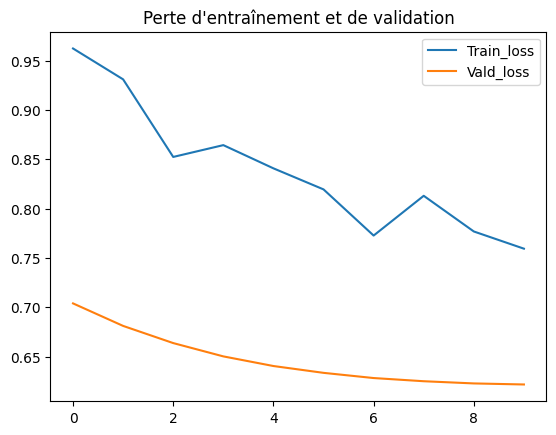

In [32]:
# LOSS CURVE

loss_train = Fex_resn50_history.history["loss"]
loss_vald = Fex_resn50_history.history["val_loss"]
plt.plot(loss_train, label = "Train_loss")
plt.plot(loss_vald, label = "Vald_loss")
plt.legend(loc = 'upper right')
plt.title("Perte d'entraînement et de validation")
plt.legend()
plt.show()

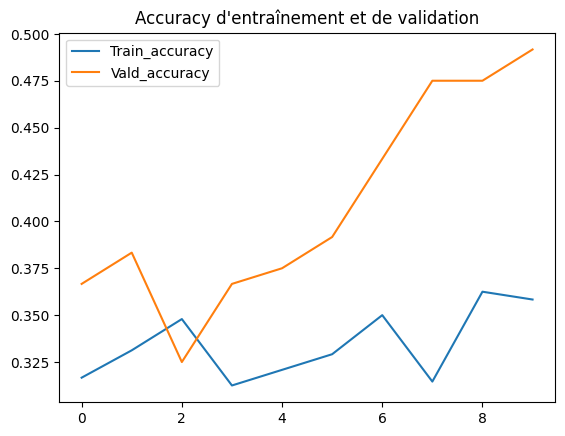

In [33]:
# ACCURACY CURVE

acc_train = Fex_resn50_history.history["accuracy"]
acc_val = Fex_resn50_history.history["val_accuracy"]
plt.plot(acc_train, label = "Train_accuracy")
plt.plot(acc_val, label = "Vald_accuracy")
plt.legend(loc = 'lower right')
plt.title("Accuracy d'entraînement et de validation")
plt.legend()
plt.show()

#### FTt_resn50.

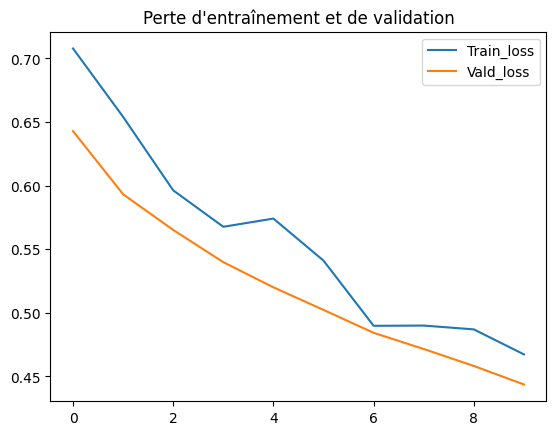

In [34]:
# LOSS CURVE

loss_train = FTt_resn50_history.history["loss"]
loss_vald = FTt_resn50_history.history["val_loss"]
plt.plot(loss_train, label = "Train_loss")
plt.plot(loss_vald, label = "Vald_loss")
plt.legend(loc = 'upper right')
plt.title("Perte d'entraînement et de validation")
plt.legend()
plt.show()

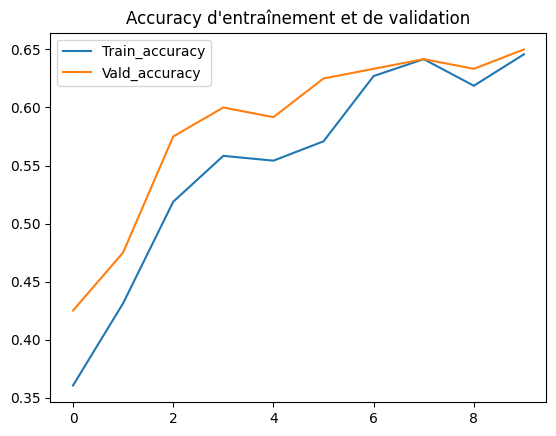

In [35]:
# ACCURACY CURVE

acc_train = FTt_resn50_history.history["accuracy"]
acc_val = FTt_resn50_history.history["val_accuracy"]
plt.plot(acc_train, label = "Train_accuracy")
plt.plot(acc_val, label = "Vald_accuracy")
plt.legend(loc = 'lower right')
plt.title("Accuracy d'entraînement et de validation")
plt.legend()
plt.show()

#### ***Fex_resn101 et FTt_resn101:***

#### Fex_resn101

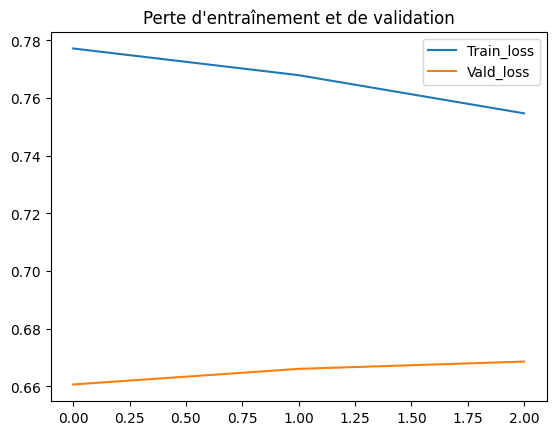

In [36]:
# LOSS CURVE

loss_train = Fex_resn101_history.history["loss"]
loss_vald = Fex_resn101_history.history["val_loss"]
plt.plot(loss_train, label = "Train_loss")
plt.plot(loss_vald, label = "Vald_loss")
plt.legend(loc = 'upper right')
plt.title("Perte d'entraînement et de validation")
plt.legend()
plt.show()

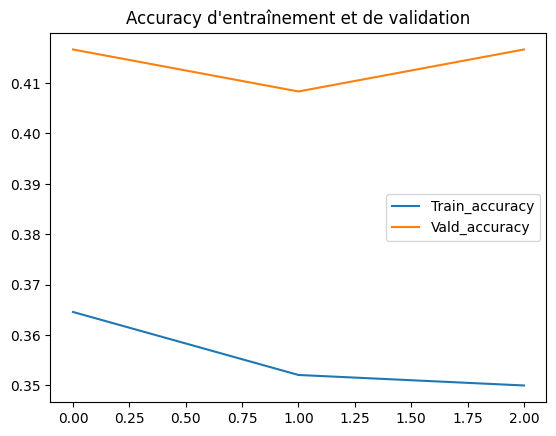

In [37]:
# ACCURACY CURVE

acc_train = Fex_resn101_history.history["accuracy"]
acc_val = Fex_resn101_history.history["val_accuracy"]
plt.plot(acc_train, label = "Train_accuracy")
plt.plot(acc_val, label = "Vald_accuracy")
plt.legend(loc = 'lower right')
plt.title("Accuracy d'entraînement et de validation")
plt.legend()
plt.show()

#### FTt_resn101

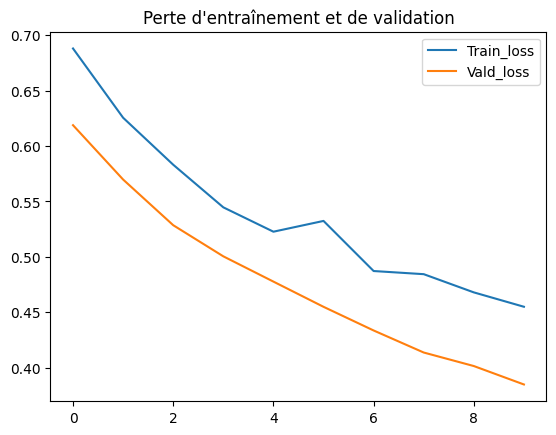

In [38]:
# LOSS CURVE

loss_train = FTt_resn101_history.history["loss"]
loss_vald = FTt_resn101_history.history["val_loss"]
plt.plot(loss_train, label = "Train_loss")
plt.plot(loss_vald, label = "Vald_loss")
plt.legend(loc = 'upper right')
plt.title("Perte d'entraînement et de validation")
plt.legend()
plt.show()

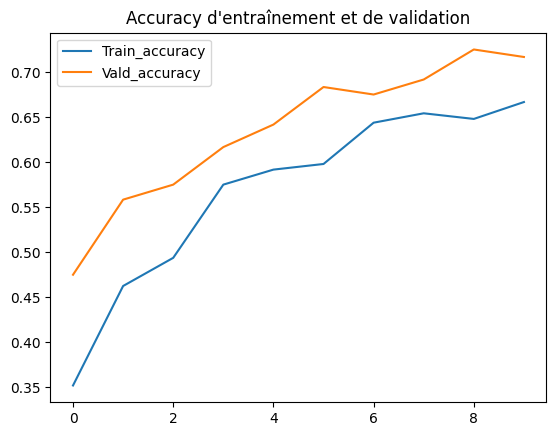

In [39]:
# ACCURACY CURVE

acc_train = FTt_resn101_history.history["accuracy"]
acc_val = FTt_resn101_history.history["val_accuracy"]
plt.plot(acc_train, label = "Train_accuracy")
plt.plot(acc_val, label = "Vald_accuracy")
plt.legend(loc = 'lower right')
plt.title("Accuracy d'entraînement et de validation")
plt.legend()
plt.show()

#### ***Fex_resn152 et FTt_resn152:***

#### Fex_resn152

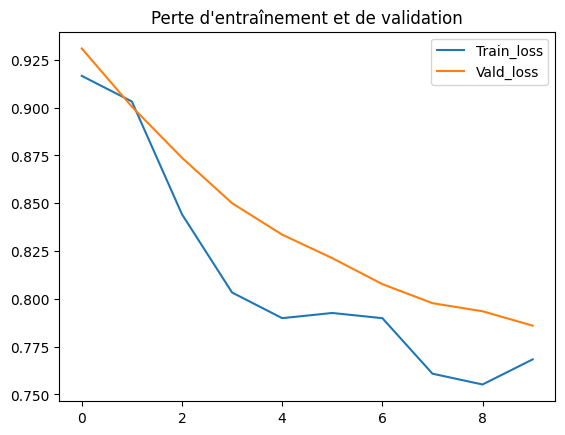

In [40]:
# LOSS CURVE

loss_train = Fex_resn152_history.history["loss"]
loss_vald = Fex_resn152_history.history["val_loss"]
plt.plot(loss_train, label = "Train_loss")
plt.plot(loss_vald, label = "Vald_loss")
plt.legend(loc = 'upper right')
plt.title("Perte d'entraînement et de validation")
plt.legend()
plt.show()

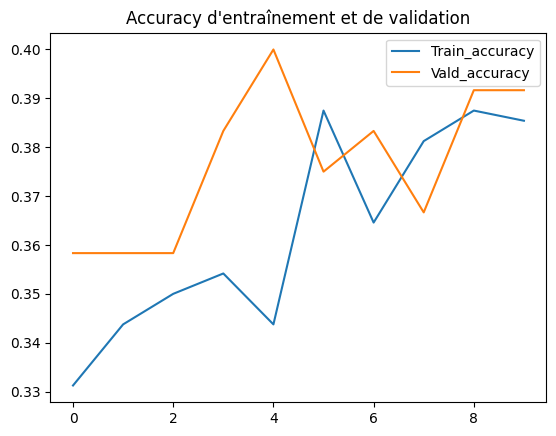

In [41]:
# ACCURACY CURVE

acc_train = Fex_resn152_history.history["accuracy"]
acc_val = Fex_resn152_history.history["val_accuracy"]
plt.plot(acc_train, label = "Train_accuracy")
plt.plot(acc_val, label = "Vald_accuracy")
plt.legend(loc = 'lower right')
plt.title("Accuracy d'entraînement et de validation")
plt.legend()
plt.show()

#### FTt_resn152

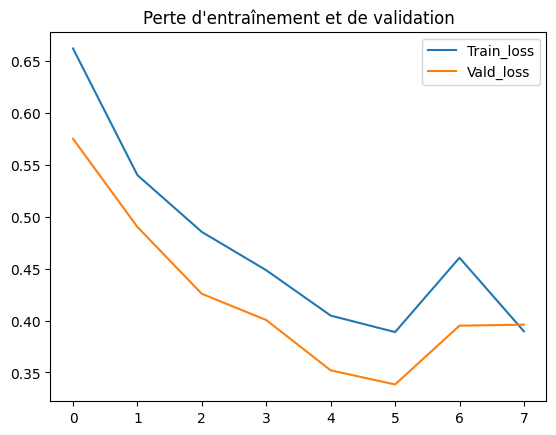

In [42]:
# LOSS CURVE

loss_train = FTt_resn152_history.history["loss"]
loss_vald = FTt_resn152_history.history["val_loss"]
plt.plot(loss_train, label = "Train_loss")
plt.plot(loss_vald, label = "Vald_loss")
plt.legend(loc = 'upper right')
plt.title("Perte d'entraînement et de validation")
plt.legend()
plt.show()

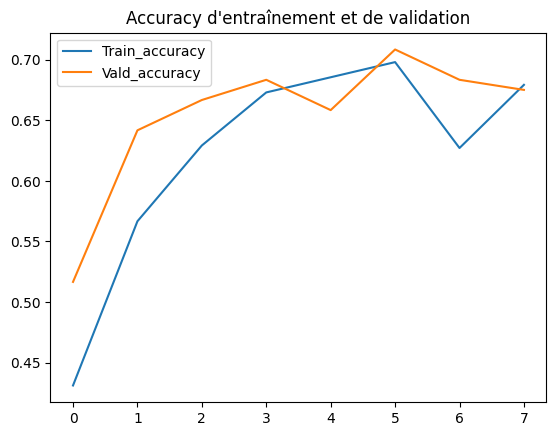

In [43]:
# ACCURACY CURVE

acc_train = FTt_resn152_history.history["accuracy"]
acc_val = FTt_resn152_history.history["val_accuracy"]
plt.plot(acc_train, label = "Train_accuracy")
plt.plot(acc_val, label = "Vald_accuracy")
plt.legend(loc = 'lower right')
plt.title("Accuracy d'entraînement et de validation")
plt.legend()
plt.show()

# **EVALUATION DES MODELES**

#### **Les modèles sont évalués sur les données de test.**

In [44]:
test_loss, test_acc = Fex_resn50.evaluate(Test,Test_labels)
print("The test loss of Fex_resn50 is: ", test_loss*100)
print("The best accuracy of Fex_resn50 is: ", test_acc*100)

10/10 [==============================] - 2s 164ms/step - loss: 0.6254 - accuracy: 0.4200
The test loss of Fex_resn50 is:  62.5353217124939
The best accuracy of Fex_resn50 is:  41.999998688697815


In [45]:
test_loss, test_acc = FTt_resn50.evaluate(Test,Test_labels)
print("The test loss of FTt_resn50 is: ", test_loss*100)
print("The best accuracy of FTt_resn50 is: ", test_acc*100)

10/10 [==============================] - 1s 107ms/step - loss: 0.5054 - accuracy: 0.6333
The test loss of FTt_resn50 is:  50.544655323028564
The best accuracy of FTt_resn50 is:  63.333332538604736


In [46]:
test_loss, test_acc = Fex_resn101.evaluate(Test,Test_labels)
print("The test loss of Fex_resn101 is: ", test_loss*100)
print("The best accuracy of Fex_resn101 is: ", test_acc*100)

10/10 [==============================] - 2s 152ms/step - loss: 0.6830 - accuracy: 0.3833
The test loss of Fex_resn101 is:  68.30044984817505
The best accuracy of Fex_resn101 is:  38.333332538604736


In [47]:
test_loss, test_acc = FTt_resn101.evaluate(Test,Test_labels)
print("The test loss of FTt_resn101 is: ", test_loss*100)
print("The best accuracy of FTt_resn101 is: ", test_acc*100)

10/10 [==============================] - 2s 176ms/step - loss: 0.4591 - accuracy: 0.7133
The test loss of FTt_resn101 is:  45.910099148750305
The best accuracy of FTt_resn101 is:  71.33333086967468


In [48]:
test_loss, test_acc = Fex_resn152.evaluate(Test,Test_labels)
print("The test loss of Fex_resn152 is: ", test_loss*100)
print("The best accuracy of Fex_resn152 is: ", test_acc*100)

10/10 [==============================] - 2s 220ms/step - loss: 0.7944 - accuracy: 0.4567
The test loss of Fex_resn152 is:  79.43774461746216
The best accuracy of Fex_resn152 is:  45.66666781902313


In [49]:
test_loss, test_acc = FTt_resn152.evaluate(Test,Test_labels)
print("The test loss of FTt_resn152 is: ", test_loss)
print("The best accuracy of FTt_resn152 is: ", test_acc)

10/10 [==============================] - 2s 224ms/step - loss: 0.6816 - accuracy: 0.5733
The test loss of FTt_resn152 is:  0.681599497795105
The best accuracy of FTt_resn152 is:  0.5733333230018616


*Nous constatons que le meilleur modèles est FTt_resn101.*

# **UTILISATION DU MEILLEUR MODELE.**

#### **Utilisa tion de callback pour stocker les poids du meilleur modèle.**
Le modèle s’entraînera pendant 20 epochs mais nous utiliserons ModelCheckpoint pour stocker les poids de l’epoch la plus performante parmi ces 20 epochs..

In [50]:
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath="BestMod_weights.hdf5", monitor = 'val_accuracy',verbose=1, save_best_only=True)

#### **Entrainement du modèle:**

In [52]:
FTt_resn101_hist = FTt_resn101.fit(train_generator.flow(Train, Train_labels, batch_size=BATCH_SIZE), epochs = 20, callbacks=[checkpointer], validation_data = (Vald,Vald_labels))

Epoch 1/20
30/30 [==============================] - ETA: 0s - loss: 0.4394 - accuracy: 0.6792
Epoch 1: val_accuracy improved from 0.72500 to 0.75833, saving model to BestMod_weights.hdf5
30/30 [==============================] - 52s 2s/step - loss: 0.4394 - accuracy: 0.6792 - val_loss: 0.3687 - val_accuracy: 0.7583
Epoch 2/20
30/30 [==============================] - ETA: 0s - loss: 0.4419 - accuracy: 0.6854
Epoch 2: val_accuracy did not improve from 0.75833
30/30 [==============================] - 14s 469ms/step - loss: 0.4419 - accuracy: 0.6854 - val_loss: 0.3560 - val_accuracy: 0.7583
Epoch 3/20
30/30 [==============================] - ETA: 0s - loss: 0.4009 - accuracy: 0.7250
Epoch 3: val_accuracy did not improve from 0.75833
30/30 [==============================] - 11s 362ms/step - loss: 0.4009 - accuracy: 0.7250 - val_loss: 0.3493 - val_accuracy: 0.7500
Epoch 4/20
30/30 [==============================] - ETA: 0s - loss: 0.4081 - accuracy: 0.7125
Epoch 4: val_accuracy improved from 

#### **Chargement de notre classifeur avec les poids du meilleur modèle:**

In [55]:
FTt_resn101.load_weights("BestMod_weights.hdf5")

#### **Sauvegarde des poids.**

In [68]:
from keras.saving.legacy.save import save_weights
FTt_resn101.save_weights("/content/sample_data/BestMod_weights.hdf5")

#### **Prédiction sur les données de Test**

In [56]:
test_loss, test_acc = FTt_resn101.evaluate(Test,Test_labels)
print("The test loss of Fex_resn101 is: ", test_loss*100)
print("The best accuracy of Fex_resn101 is: ", test_acc*100)

10/10 [==============================] - 2s 179ms/step - loss: 0.3594 - accuracy: 0.7567
The test loss of Fex_resn101 is:  35.936176776885986
The best accuracy of Fex_resn101 is:  75.66666603088379


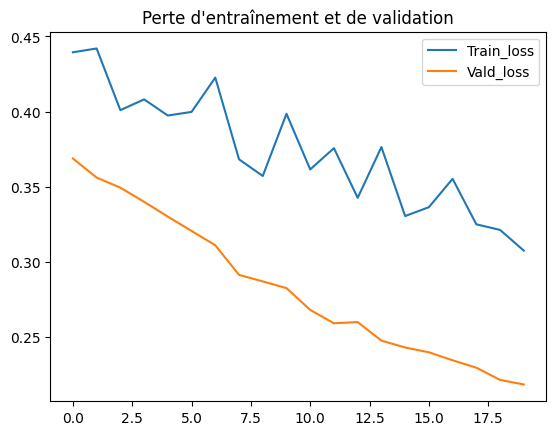

In [57]:
# LOSS CURVE

loss_train = FTt_resn101_hist.history["loss"]
loss_vald = FTt_resn101_hist.history["val_loss"]
plt.plot(loss_train, label = "Train_loss")
plt.plot(loss_vald, label = "Vald_loss")
plt.legend(loc = 'upper right')
plt.title("Perte d'entraînement et de validation")
plt.legend()

plt.show()

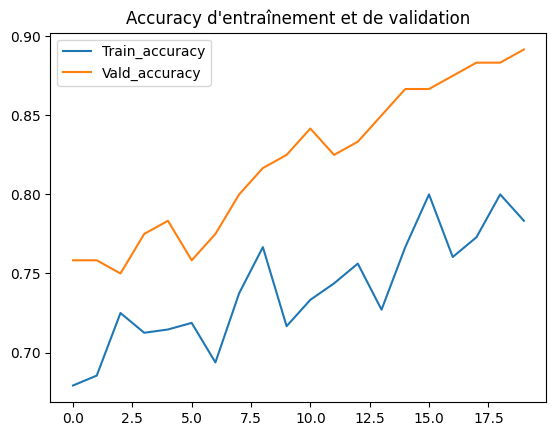

In [58]:
# ACCURACY CURVE

acc_train = FTt_resn101_hist.history["accuracy"]
acc_val = FTt_resn101_hist.history["val_accuracy"]
plt.plot(acc_train, label = "Train_accuracy")
plt.plot(acc_val, label = "Vald_accuracy")
plt.legend(loc = 'lower right')
plt.title("Accuracy d'entraînement et de validation")
plt.legend()

plt.show()

#### **Sauvegarde du modèle complet**

In [59]:
FTt_resn101.save('/content/gdrive/MyDrive/Breast_Cancer_DDSM/resn101.h5')

In [60]:
FTt_resn101.save('/content/sample_data/resn101.h5')

# **UTILISATION DU MEILLEUR MODELE EN VUE DE PREDIRE UNE NOUVELLE MAMMOGRAPHIE.**
###### *Nous avons ici choisi trois images (une normale, une bénigne et une cancer) d'un autre ensemble de données et avons prédit la classe de chaque image.*

---




#### **Connecter Google drive à Google colab.**



In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

#### Chargement du modèle:

In [61]:
from tensorflow import keras
FTt_resn101 = keras.models.load_model('/content/gdrive/MyDrive/Breast_Cancer_DDSM/resn101.h5')

In [ ]:
FTt_resn101 = keras.models.load_model('/content/sample_data/resn101.h5')

#### **Cancer**.

#### Chargement de l'image:

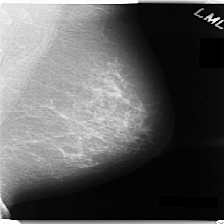

In [62]:
imgC = tf.keras.preprocessing.image.load_img("/content/gdrive/MyDrive/Breast_Cancer_DDSM/Applications/Cancer/306_C_0035_1.LEFT_MLO.LJPEG.1_highpass.png", target_size=(224, 224))
#imgC_array = tf.keras.preprocessing.image.img_to_array(imgC)
#imgC_array = np.array([imgC_array]) 
imgC


#### Prédiction:

In [63]:
# Prédiction 

x = np.expand_dims(imgC, axis=0)
images = np.vstack([x])
classes = np.argmax(FTt_resn101.predict(images, batch_size=10), axis=-1)
print("La classe prédite est :",classes)

1/1 [==============================] - 3s 3s/step
La classe prédite est : [0]


#### **Bénigne.**

#### Chargement de l'image:

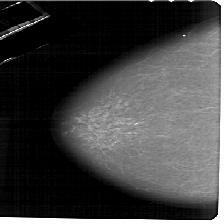

In [64]:
imgB = tf.keras.preprocessing.image.load_img("/content/gdrive/MyDrive/Breast_Cancer_DDSM/Applications/Benign/307_A_1267_1.LEFT_CC.LJPEG.1_highpass.png", target_size=(224, 224))
#imgB_array = tf.keras.preprocessing.image.img_to_array(imgB)
#imgB_array = np.array([imgB_array]) 
imgB


#### Prédiction:

In [65]:
# Prédiction 

x = np.expand_dims(imgB, axis=0)
images = np.vstack([x])
classes = np.argmax(FTt_resn101.predict(images, batch_size=10), axis=-1)
print("La classe prédite est :",classes)

1/1 [==============================] - 0s 44ms/step
La classe prédite est : [1]


#### **Normale.**

#### Chargement de l'image:

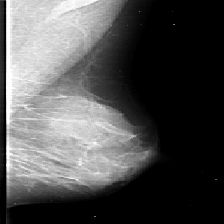

In [66]:
imgN = tf.keras.preprocessing.image.load_img("/content/gdrive/MyDrive/Breast_Cancer_DDSM/Applications/Normal/102_A_0039_1.RIGHT_MLO.LJPEG.1_highpass.png", target_size=(224, 224))
#imgN_array = tf.keras.preprocessing.image.img_to_array(imgN)
#imgN_array = np.array([imgN_array]) 
imgN


#### Prédiction:

In [67]:
# Prédiction 
x = np.expand_dims(imgN, axis=0)
images = np.vstack([x])
classes = np.argmax(FTt_resn101.predict(images, batch_size=10), axis=-1)
print("La classe prédite est :",classes)

1/1 [==============================] - 0s 33ms/step
La classe prédite est : [0]
